# Exploration of NHL Player Statistics by Birth Month
> Work in progress post about the kinds of careers NHL player tend to have based on their birth month

- comments: true

In [60]:
#hide
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook

players_df = pd.read_csv(r"C:\Users\jacks\Development\Python\jcrs-blog\_notebooks\person.csv")
roster_df = pd.read_csv(r"C:\Users\jacks\Development\Python\jcrs-blog\_notebooks\roster.csv")
teams_df = pd.read_csv(r"C:\Users\jacks\Development\Python\jcrs-blog\_notebooks\teams.csv")
playerStats_df = pd.read_csv(r"C:\Users\jacks\Development\Python\jcrs-blog\_notebooks\playerStats.csv")

nhl_stats_df = playerStats_df[(playerStats_df['league_id'] == 133) & (playerStats_df['games'] > 9)]

def returnGrouping(month):
    early = ['January', 'February', 'March']
    earlyMid = ['April', 'May', 'June']
    lateMid = ['July', 'August', 'September']
    late = ['October', 'November', 'December']
    if month in early:
        return 'Early'
    elif month in earlyMid:
        return 'Early Middle'
    elif month in lateMid:
        return 'Late Middle'
    elif month in late:
        return 'Late'
    return 'None'

players_df['birth_date'] = pd.to_datetime(players_df['birth_date'], format="%Y-%m-%d %H:%M:%S-%f")
players_df['birth_month_number'] = players_df['birth_date'].dt.month
players_df['birth month'] = players_df['birth_date'].dt.month_name()
players_df['Year Grouping'] = players_df['birth month'].apply(returnGrouping)
players_df = players_df.sort_values(by='birth_month_number')

nhl_player_stats_df = pd.merge(left=nhl_stats_df, right=players_df, on='person_id')
nhl_player_stats_team_df = pd.merge(left=nhl_player_stats_df, right=teams_df, on='team_id')
nhl_player_stats_team_df = nhl_player_stats_team_df.sort_values(by='birth_month_number')

In Malcolm Gladwell's book Outliers, which coined the now pervasive ten thousand hour rule, he also discusses an observation on the state of professional hockey. Specifically, he finds that professional players are more likely to be born at the beginning of the year than at the end. That has stuck with me for years after reading the book as an interesting biproduct of how the minor hockey system weeds out players, as Gladwell suggests it is a result of players being born in January having an age advantage due to the cutoff period for yearly hockey leagues being just before their birthdates.

I've wondered about that validity of it, it seemed like something that could have just been a result of cherry picking specific leagues (as his primary example is the WHL, not the NHL). I was also curious that if it did prove to be true would it be extendable to other areas of performance? Are players born in September more likely to become goal scoring phenoms like Alex Ovechkin (born september 17th)? What about January born players, are they likely to score a ton of points like current superstar Connor McDavid (born January 13th)? 

Luckily, the NHL provides easy access to this data through its open API, and with the power of python its easy enough to see that in fact Gladwell's claim that more players from the start of the year make it to the big leagues does hold up:

In [44]:
#hide
nhl_month_stats_df = nhl_player_stats_team_df[[
    'birth month',
    'assists',
    'goals',
    'pim',
    'shots',
    'games',
    'hits',
    'power_play_goals',
    'power_play_assists',
    'blocked_shots',
    'shifts',
]]
rename_map = {'power_play_goals': 'power play goals', 
              'power_play_assists': 'power play assists',
              'blocked_shots': 'blocked shots',
}
nhl_month_stats_df = nhl_month_stats_df.rename(columns=rename_map)
nhl_month_stats_df['points'] = nhl_month_stats_df['goals'] + nhl_month_stats_df['assists']
nhl_month_stats_df['goals per game'] = nhl_month_stats_df['goals'] / nhl_month_stats_df['games'] 
nhl_month_stats_df['assists per game'] = nhl_month_stats_df['assists'] / nhl_month_stats_df['games'] 
nhl_month_stats_df['points per game'] = nhl_month_stats_df['points'] / nhl_month_stats_df['games'] 
nhl_month_stats_df['power play points'] = nhl_month_stats_df['power play goals'] + nhl_month_stats_df['power play assists'] 
nhl_month_stats_df['shooting percentage'] = nhl_month_stats_df['goals'] / nhl_month_stats_df['shots'] * 100

In [57]:
pd.DataFrame(players_df['birth month'].value_counts(sort=False))

,birth month
January,321
February,331
March,305
April,299
May,304
June,256
July,274
August,230
September,212
October,222


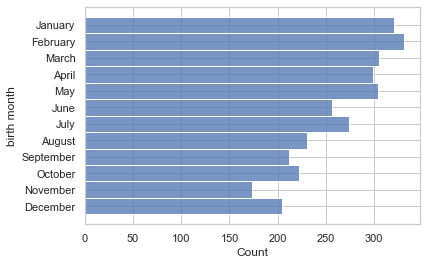

In [58]:
import seaborn as sb

sb.set_theme(style="whitegrid")
ax = sb.histplot(y="birth month", data=players_df)

There is Gladwell's trend, very clearly displayed in the pool of players who have played more than 9 games since the NHL lockout in 2005. Being born in February looks to give you the best chance to make the NHL with 331 players born that month, with November being the far worst with a paltry 173 players. A better way to visualize this is perhaps to pool the players into 4 categories based on the time of year they are born. Lets take a look with four categories, Early (January, February, March), Early Middle (April, May, June), Late Middle (July, August, September), and Late (October, November, December).

In [62]:
pd.DataFrame(players_df['Year Grouping'].value_counts(sort=False))

,Year Grouping
Early,957
Early Middle,859
Late Middle,716
Late,600


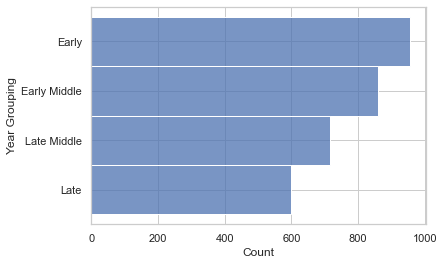

In [61]:
ax = sb.histplot(y='Year Grouping', data=players_df)

The trend is very clear. There are 957 players born in the 'Early' grouping months, while there are only 600 players born in the 'Late' grouping. That means the for every 10 players  born in the months of October, November, or December who makes the NHL there are roughly 16 making it from the months of January, February, or March. This is just a visualization and its not attempting to prove statistically significance, but those numbers certainly suggest a very 
pronounced correlation.

In [42]:
#hide
from numpy import number
from bokeh.models import ColumnDataSource, HBar, Segment, Rect, Select, CustomJS
from bokeh.layouts import column
from bokeh.palettes import Colorblind

output_notebook()
x_value = 'assists'
y_value = 'birth month'

categories = nhl_month_stats_df[y_value].unique().tolist()

# if lower bound is less than zero, zero it
def greaterThanZero(x):
    return x if (x > 0) else 0

sources = {}
x_axis_values = nhl_month_stats_df.select_dtypes([number]).columns
for x_axis_value in x_axis_values:
    df = nhl_month_stats_df[[
        y_value, 
        x_axis_value, 
    ]]
    groups = df.groupby(y_value)
    q1 = groups.quantile(q=0.25, interpolation='midpoint').reindex(categories)
    q2 = groups.quantile(q=0.5).reindex(categories)
    q3 = groups.quantile(q=0.75).reindex(categories)
    iqr = q3 - q1
    upper = q3 + 1.5*iqr
    lower = q1 - 1.5*iqr
    lower[x_axis_value] = lower[x_axis_value].apply(greaterThanZero)
    
    source_dict = {
        'y': categories,
        'lower': lower[x_axis_value],
        'q1': q1[x_axis_value],
        'q2': q2[x_axis_value],
        'q3': q3[x_axis_value],
        'upper': upper[x_axis_value]
    }
    
    source = ColumnDataSource(data=source_dict)
    
    sources[x_axis_value] = {
        'source': source,
    }
    
tooltips = """
<div>
    <span style="font-size: 12px; font-weight: bold;">@y</span>&nbsp;
</div>
<div>
    <span style="font-size: 10px;">Lower bounds: @lower</span><br>
    <span style="font-size: 10px;">First quartile: @q1</span><br>
    <span style="font-size: 10px;">Mean: @q2</span><br>
    <span style="font-size: 10px;">Third quartile: @q3</span><br>
    <span style="font-size: 10px;">Upper bounds: @upper</span>
</div>
"""
p = figure(y_range=categories, tooltips=tooltips)

source = sources[x_value]['source']

hbar = HBar(
        y='y', 
        height=0.6,
        left='q1',
        right='q3',
        fill_color = Colorblind[8][0]
)

lower_segment = Segment(x0='lower', y0='y', x1='q1' ,y1='y')
upper_segment = Segment(x0='q3', y0='y', x1='upper' ,y1='y')
lower_rect = Rect(x='lower', y='y', width=0.001, height=0.8)
middle_rect = Rect(x='q2', y='y', width=0.001, height=0.8)
upper_rect = Rect(x='upper', y='y', width=0.001, height=0.8)

p.add_glyph(source, hbar)
p.add_glyph(source, lower_segment)
p.add_glyph(source, upper_segment)
p.add_glyph(source, lower_rect)
p.add_glyph(source, middle_rect)
p.add_glyph(source, upper_rect)

x_select = Select(title="Select Stat", options=x_axis_values.tolist(), value=x_value)
x_select.js_on_change("value", CustomJS(args=dict(source=source, sources=sources), 
code="""
    source.data = sources[this.value]['source'].data
    source.change.emit();
    lower_rect_source.data = sources[this.value]['lower_rect_source'].data
    lower_rect_source.change.emit();
    middle_rect_source.data = sources[this.value]['middle_rect_source'].data
    middle_rect_source.change.emit();
    upper_rect_source.data = sources[this.value]['upper_rect_source'].data
    upper_rect_source.change.emit();
"""))
layout = column(p, x_select)

output_file('boxplot.html')
# show the results
show(layout)
#q1.index.values

Loading BokehJS ...

In [4]:
#hide_input
from IPython.core.display import display, HTML
display(HTML('./boxplot.html'))